In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pretty_midi
!pip install np_utils

     |████████████████████████████████| 5.6 MB 22.4 MB/s 
     |████████████████████████████████| 51 kB 9.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=861800afd84719c80169e32c124be7a61e24434d376f091bb177b20951b52e2b
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
     |████████████████████████████████| 61 kB 687 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=7fb3d7683e012763f0ac83103c0417dd019b2491df31f7e08a05687c21e77fc8
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [ ]:
import os
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
import pretty_midi
from PIL import Image
import matplotlib.pyplot as plt

import time
import logging
import pathlib
from tqdm.autonotebook import tqdm
import pandas as pd
import np_utils

import random

from IPython import display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [ ]:
tf.version.VERSION

'2.7.0'

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [ ]:
path = '/content/drive/MyDrive/maestro-v3.0.0-midi/maestro-v3.0.0/2018'

os.chdir(path)
midi_paths = []
for fn in os.listdir():
  midi_paths.append(path+'/'+fn)

os.chdir('/content')

In [ ]:
new_dir = '/content/drive/MyDrive/maestro_midi_images/'

In [ ]:
FS = 10
midi_dims = 127
seq_len = 250

In [ ]:
def midi2proll(filename):
  midi_pretty_format = pretty_midi.PrettyMIDI(filename)
  midi_piano = midi_pretty_format.instruments[0]
  midi_piano_roll = midi_piano.get_piano_roll(fs=FS)
  return midi_piano_roll # returns piano roll in format (128 notes, time)

def proll2midi(proll):
  notes, frames = proll.shape
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=0)

  proll = np.pad(proll, [(0, 0), (1, 1)], 'constant')
  velocity_changes = np.nonzero(np.diff(proll).T)

  prev_velocities = np.zeros(notes, dtype=int)
  note_on_time = np.zeros(notes)

  for time, note in zip(*velocity_changes):
      velocity = proll[note, time + 1]
      time = time / FS
      if velocity > 0:
          if prev_velocities[note] == 0:
              note_on_time[note] = time
              prev_velocities[note] = velocity
      else:
          pm_note = pretty_midi.Note(
              velocity=prev_velocities[note],
              pitch=note,
              start=note_on_time[note],
              end=time)
          instrument.notes.append(pm_note)
          prev_velocities[note] = 0
  pm.instruments.append(instrument)
  return pm

def proll2img(proll, show=False):
  im = Image.fromarray(np.uint8(proll))
  if show:
    plt.imshow(np.asarray(im), aspect='auto', cmap='gray')
  return im

def proll2notelist(proll):
  pnotelist = []
  for t, tarr in enumerate(np.transpose(proll)):
    pnotelist.append([])
    for n, val in enumerate(tarr):
      if(val > 0):
        pnotelist[t].append(str(n))          
  return pnotelist

def pnotelist2proll(pnotelist):
  proll = np.zeros((midi_dims, len(pnotelist)))
  for t, notes in enumerate(pnotelist):
    for n in notes:
      proll[n][t] = 1
  return proll

In [ ]:
def transform_pnotelist(pnotelist):
  transformed_pnotelist = []
  for notes in pnotelist:
    transformed_pnotelist.append(','.join(notes))
  return np.asarray(transformed_pnotelist)

def untransform_pnotelist(pnotelist):
  untransformed_pnotelist = []
  for t in pnotelist:
    notes = t.split(',')
    tmp = []
    for n in notes:
      if n is not '':
        tmp.append(int(n))
    untransformed_pnotelist.append(tmp)
  return untransformed_pnotelist

def get_musical_corpus(filepaths, show_progress=True):
  all_seq = []
  iter = enumerate(filepaths)
  if(show_progress):
    iter = tqdm(enumerate(filepaths), total=len(filepaths))
  for i, fp in iter:
    all_seq.append(transform_pnotelist(proll2notelist(midi2proll(fp))))
  all_seq = np.asarray(all_seq)
  return all_seq

def transform_musical_corpus(musical_corpus):
  data_in = []
  data_out = []
  for i in range(0, len(musical_corpus) - seq_len, 1):
    sequence_in = musical_corpus[i:i + seq_len]
    sequence_out = musical_corpus[i + seq_len]
    data_in.append(sequence_in)
    data_out.append(sequence_out)
  return (np.asarray(data_in), np.asarray(data_out))

def pad_array(arr, target_length):
  if target_length < np.shape(arr)[0]:
    return arr[:target_length]
  padding = np.full((target_length - np.shape(arr)[0],), '')
  return np.concatenate([arr, padding])

In [ ]:
vocab_instances = 8

# first 8 to retrieve vocabulary
musical_corpus = np.concatenate(get_musical_corpus(midi_paths[:vocab_instances]))

FINAL_VOCAB_SIZE = 50000

vocab_size = np.shape(np.unique(musical_corpus))[0]
print('Base Vocab Size', vocab_size)

vec = layers.TextVectorization(max_tokens=FINAL_VOCAB_SIZE + 1, standardize=None, split=None)
vec.adapt(musical_corpus)
vocabulary = vec.get_vocabulary()
vocabulary.remove('[UNK]')
vocab_size = len(vocabulary)

print('Final Vocab Size', len(vocabulary))

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Base Vocab Size 15688
Final Vocab Size 15688


In [ ]:
ids_from_chars = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=vocabulary, mask_token=None)
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
def efficient_get_data_vec(start, end=None):
  if end is None:
    end = start
    start = 0
  musical_corpus = np.concatenate(get_musical_corpus([midi_paths[start]], show_progress=False))
  data_in, data_out = transform_musical_corpus(musical_corpus)
  data_in_vectorized = ids_from_chars(data_in)
  data_out_vectorized = ids_from_chars(data_out)
  del data_in, data_out
  for i in tqdm(range(start+1, end), total=end-start-1):
    musical_corpus = np.concatenate(get_musical_corpus([midi_paths[i]], show_progress=False))
    data_in, data_out = transform_musical_corpus(musical_corpus)
    data_in_vectorized = tf.concat([data_in_vectorized, ids_from_chars(data_in)], axis=0)
    data_out_vectorized = tf.concat([data_out_vectorized, ids_from_chars(data_out)], axis=0)
  del data_in, data_out, musical_corpus
  return (data_in_vectorized, data_out_vectorized)

In [ ]:
# ran 20 epochs with first 8, now running 10 epochs with first 16
data_vectorized = efficient_get_data_vec(16)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
data_test_vectorized = efficient_get_data_vec(24, 26)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
TRAIN_TOTAL_SIZE = len(data_vectorized[0])
TEST_TOTAL_SIZE = len(data_test_vectorized[0])
BATCH_SIZE = 128
N_TRAIN_BATCHES = int(TRAIN_TOTAL_SIZE/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_TOTAL_SIZE/BATCH_SIZE)

print(TRAIN_TOTAL_SIZE)
print(TEST_TOTAL_SIZE)

158462
18628


In [ ]:
np.sum(np.equal(data_test_vectorized[1], 0))

9853

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(data_vectorized)
    .cache()
    .shuffle(10000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(data_test_vectorized)
    .cache()
    .shuffle(10000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((128, 250), (128,)), types: (tf.int64, tf.int64)>
<PrefetchDataset shapes: ((128, 250), (128,)), types: (tf.int64, tf.int64)>


In [ ]:
# del data_in, data_out, data_in_vectorized, data_out_vectorized, data_vectorized, train_dataset

# Model

In [ ]:
vocab_size = len(ids_from_chars.get_vocabulary())
rnn_units = 512
e_dim = 128
dff = 256
dropout_prop = 0.3
input_shape = (seq_len,)

In [ ]:
def MusicGenerator(vocab_size, e_dim, rnn_units, dff, dropout_prop):
  model = tf.keras.Sequential()
  model.add(layers.Embedding(vocab_size, e_dim, input_shape=input_shape))
  model.add(layers.GRU(rnn_units, return_sequences=True))
  model.add(layers.Dropout(dropout_prop))
  model.add(layers.GRU(rnn_units, return_sequences=True))
  model.add(layers.Dropout(dropout_prop))
  model.add(layers.GRU(rnn_units))
  model.add(layers.Dense(dff))
  model.add(layers.Dropout(dropout_prop))
  model.add(layers.Dense(vocab_size))
  model.add(layers.Activation('softmax'))
  return model

In [ ]:
model = MusicGenerator(
    vocab_size=vocab_size,
    e_dim=e_dim,
    rnn_units=rnn_units,
    dff=dff,
    dropout_prop=dropout_prop)

In [ ]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          2008192   
                                                                 
 gru (GRU)                   (None, 250, 512)          986112    
                                                                 
 dropout (Dropout)           (None, 250, 512)          0         
                                                                 
 gru_1 (GRU)                 (None, 250, 512)          1575936   
                                                                 
 dropout_1 (Dropout)         (None, 250, 512)          0         
                                                                 
 gru_2 (GRU)                 (None, 512)               1575936   
                                                                 
 dense (Dense)               (None, 256)               1

In [ ]:
model.load_weights("/content/drive/MyDrive/rnn-music-midis/layered-grus-models/models_20_epochs")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0008), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[tf.metrics.SparseCategoricalAccuracy()])

# Train Model

**Setup Checkpoints**

In [ ]:
!pwd

/content


In [ ]:
checkpoint_path = "/content/drive/MyDrive/rnn-music-midis/models/modelcp_tmp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True)

**Fit Model**

Might need to reduce vocabulary size as the number of parameters is enormous.

In [ ]:
EPOCHS = 5

In [ ]:
# history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback], validation_data=test_dataset)

Epoch 1/5
1237/1237 [==============================] - 830s 668ms/step - loss: 1.8010 - sparse_categorical_accuracy: 0.7034 - val_loss: 3.5247 - val_sparse_categorical_accuracy: 0.5742
Epoch 2/5
1237/1237 [==============================] - 825s 667ms/step - loss: 1.7032 - sparse_categorical_accuracy: 0.6913 - val_loss: 3.4923 - val_sparse_categorical_accuracy: 0.5719
Epoch 3/5
1237/1237 [==============================] - 822s 664ms/step - loss: 1.5907 - sparse_categorical_accuracy: 0.6997 - val_loss: 3.7960 - val_sparse_categorical_accuracy: 0.5713
Epoch 4/5
1237/1237 [==============================] - 821s 664ms/step - loss: 1.5162 - sparse_categorical_accuracy: 0.7068 - val_loss: 3.6629 - val_sparse_categorical_accuracy: 0.5720
Epoch 5/5
1237/1237 [==============================] - 823s 665ms/step - loss: 1.4615 - sparse_categorical_accuracy: 0.7128 - val_loss: 3.7811 - val_sparse_categorical_accuracy: 0.5736


In [ ]:
model.evaluate(test_dataset)

145/145 [==============================] - 15s 104ms/step - loss: 12.8996 - sparse_categorical_accuracy: 0.0501


[12.899648666381836, 0.050053879618644714]

# Generate Text

**Parameters**

In [ ]:
temperature = 0.005

start = np.random.randint(0, len(data_vectorized[0]))
pattern = list(data_vectorized[0][start].numpy())
prediction_output = []

for note_index in tqdm(range(250)):
  prediction_input = np.reshape(pattern, (1, len(pattern), 1))
  prediction = model.predict(prediction_input, verbose=0)
  
  prediction[0][0] = 0 # set 'UNK' probability to 0
  # prediction[0][1] = 0 # set '' probability to 0
  prediction = prediction / temperature
  
  # index = tf.random.categorical(prediction, 1).numpy()[0][0]
  index = np.argmax(prediction)
  
  result = chars_from_ids(int(index)).numpy().decode('utf-8')
  prediction_output.append(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]

  0%|          | 0/250 [00:00<?, ?it/s]

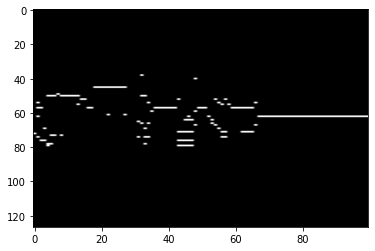

In [ ]:
proll = pnotelist2proll(untransform_pnotelist(prediction_output)) * 64
img = proll2img(proll, show=True)

In [ ]:
target_dir = '/content/drive/MyDrive/rnn-music-midis/'

In [ ]:
proll2midi(proll).write(target_dir + str(len(os.listdir(target_dir))) + '.mid')

In [ ]:
model.save_weights("/content/drive/MyDrive/rnn-music-midis/layered-grus-models/models_30_epochs")